# Proyecto Módulo 1
## Análisis de Venta Global de Videojuegos (2016)

## Objetivo

Análisis de información de venta global por regiones y plataformas para identificar patrones de éxito que puedan servir como base para planeación y estrategias futuras.

### 1. Importación de librerías 



In [1]:
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns


### 2. Lectura de Database

In [2]:
games_df = pd.read_csv('/datasets/games.csv')
games_df.info()
print(games_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                                   Name Platform  Year_of_Release  \
8524  NPPL: Championship Paintball 2009      PS3           2008.0   
3652            Assassin's Creed: Unity       PC           2014.0   
1731                 Fallout: New 

### 3. Preparación de datos

#### 3.1 Preparando nombres de columnas

In [3]:
#Estandarizando nombres de columnas a minúsculas

games_df.columns = games_df.columns.str.lower()


#### 3.2 Identificando faltantes

In [4]:
#Identificando datos faltantes 
games_df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### 3.3 Preparando "year_of_release"

In [5]:
#Dejando valores vacíos y cambiando datos a tipo numérico en "year_of_release"
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release'])

#Sustituyendo datos vacíos en "year_of_release" por 0:
games_df['year_of_release'] = games_df['year_of_release'].fillna(0)

#Convirtiendo dato en "year_of_release" a entero:
games_df['year_of_release'] = games_df['year_of_release'].astype(int)

#Cambiando datos tipo NaN en "name" y "genre" por texto "unknown"
games_df.fillna({'name':"unknown",'genre':"unknown"},inplace=True)

In [6]:
games_df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### Nota 1:

Se ha decidido cambiar a númerico los valores en "year_of_release" para aprovechar el resto de datos en esas filas. Los datos vacíos se han sustituido por 0, con lo que se podrán seguir identificando dichos datos y se podrá mejorar la presentación del resto sin  afectar futuros calculos.

En el caso de "name" y "genre" el cambio de ausentes a "unknown" se ha considerado que no afectan para futuros cálculos. 

Para el caso de "critic_score", "user_score" y "rating" se procederá al análisis individual para determinar camino a seguir.

#### 3.4 Preparando "critic_score"

In [9]:
#Analisis de datos en "critic_score"

print(games_df['critic_score'].describe())


count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64


<AxesSubplot:xlabel='critic_score'>

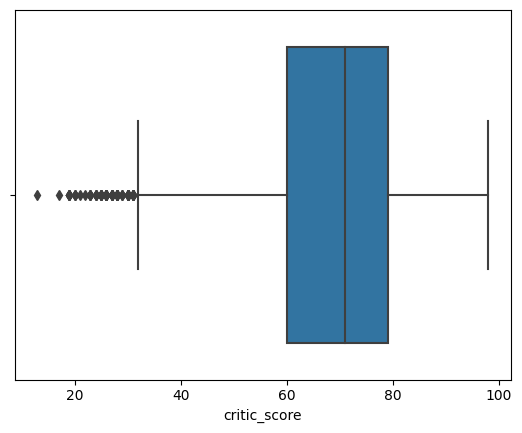

In [10]:
#Generando diagrama de caja para ilustrar mejor la descripción generada arriba
sns.boxplot(games_df['critic_score'])

#### Nota 2
Hay poca variación entre los valores de media y mediana para "critic_score", sin embargo se utilizará el valor de la mediana para sustituir los valores ausentes, dado el sesgo de datos ligeramente hacia ella. 

In [11]:
games_df['critic_score'].fillna(games_df['critic_score'].median(),inplace=True)

In [12]:
games_df['critic_score'].describe()

count    16715.000000
mean        70.010649
std          9.777494
min         13.000000
25%         71.000000
50%         71.000000
75%         71.000000
max         98.000000
Name: critic_score, dtype: float64

#### 3.5 Preparando "user_score"

In [13]:
#Analizando "user_score"
print(games_df['user_score'].sample(10))


2445     7.7
9529     tbd
9900     NaN
12200    9.3
5822     7.8
29       3.4
2986     6.2
6010     tbd
675      2.9
13824    NaN
Name: user_score, dtype: object


#### Nota 3
Para el caso de "user_score", los datos presentan valores ausentes, pero también valores de texto (tbd) lo que impide su análisis estadístico. 

Se procederá a un analisis más detallado de esos dos casos.

In [14]:
games_df['user_score'].isna().sum()

6701

In [15]:
tbd_count = games_df['user_score']=='tbd'
print(tbd_count.sum())

2424


#### Nota 4
El número de valores ausentes tipo NaN es muy alto respecto al total de datos (aprox 40%), por lo que una sustitución directa a cero o a un valor del resto da la población (media o mediana) no es lo recomendable. 
Es probable que se encuentren en esa condición porque los usuarios aún no los han probado y por ende calificado. 
Por otro lado, los valores "tbd" pueden deberse a que los usuarios ya están jugándolo pero aún no han realizado su valoración. La proporción de estos valores equivale a un 14.5%, lo que los hace suceptibles de tratarlos con un método de sustitución.

Se procederá entonces a analizar valores mayores a cero en "user_score" para determinar valor de sustitución a utilizar en "tbd".
Valores NaN se dejarán vacíos para no afectar los cálculos posteriores. 

In [16]:
#Reemplazando valores "tbd" por 0:
games_df['user_score'] = games_df['user_score'].replace('tbd',0)


In [17]:
#Conversión de columna a tipo número:
games_df['user_score'] = pd.to_numeric(games_df['user_score'])

In [18]:
#Evaluando estadísticas de valores >0:
print(games_df[games_df['user_score']>0].count())
total_data = 16715
tbd = 2424
NaN_vals = 6701
scored = total_data-tbd-NaN_vals
print()
print("Datos con valor diferente a cero o vacío inicial: ",scored)



name               7589
platform           7589
year_of_release    7589
genre              7589
na_sales           7589
eu_sales           7589
jp_sales           7589
other_sales        7589
critic_score       7589
user_score         7589
rating             7503
dtype: int64

Datos con valor diferente a cero o vacío inicial:  7590


#### Nota 5
Esta comprobación de conteo nos indica que en calificaciones originales existía un valor con valor 0. 
Por lo tanto, la conversión de "tbd" a 0 nos permite trabajar con el resto de datos mayores a 0 para encontrar valores de sustitución

count    7589.000000
mean        7.125985
std         1.497873
min         0.200000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64


<AxesSubplot:xlabel='user_score'>

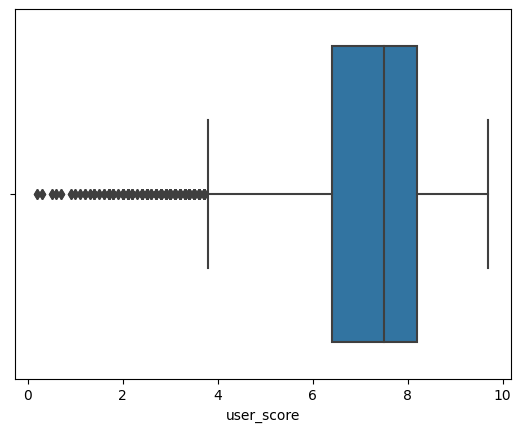

In [19]:
#Filtrado de dataframe y obtención de estadísticos
filtered_userscore = games_df[games_df['user_score']>0]

print(filtered_userscore['user_score'].describe())

sns.boxplot(filtered_userscore['user_score'])

#### Nota 6
Dado que la distribución de datos presenta un sesgo hacia la mediana (claramente notorio en diagrama de caja), se utilizará el valor de la mediana para austitución en valores 0 (anteriormente "tbd").



In [20]:
#Aplicando sustitución de valores 0 por mediana:
games_df['user_score'] = games_df['user_score'].replace(0,7.5)

In [21]:
print(games_df['user_score'].describe())

count    10014.000000
mean         7.216557
std          1.313745
min          0.200000
25%          6.800000
50%          7.500000
75%          8.000000
max          9.700000
Name: user_score, dtype: float64


#### 3.6 Preparando "rating"

In [22]:
#Revisando contenido en "rating" dado que su descripción aparece como tipo object:
print(games_df['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


In [23]:
#Conteo de valores ausentes:
games_df['rating'].isna().sum()

6766

#### Nota 7
De acuerdo con lo observado para "rating", los valores envontrados corresponden a datos tipo string que hacen referencia a categorías. Los valores ausentes seguramente se deben a ue aún no han sido evaluados por la ESRB.
No se requiere mayor preparación en esta columna.

#### 3.7 Ventas totales


In [24]:
#Cálculo de ventas totales :
games_df['total_sales'] = games_df['na_sales']+games_df['eu_sales']+games_df['jp_sales']

#### 4. Análisis de datos


#### 4.1 Juegos lanzados por año

year_of_release
0        269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


Text(0.5, 0, 'Año')

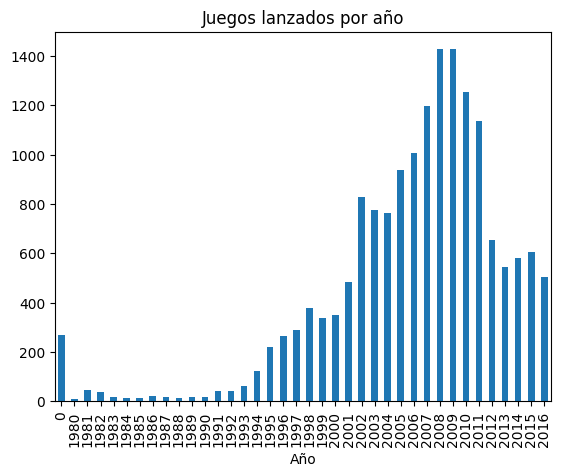

In [25]:
#Juegos lanzados por año:
print(games_df.groupby('year_of_release')['name'].count())
games_df.groupby('year_of_release')['name'].count().plot(kind='bar')
plt.title("Juegos lanzados por año")
plt.xlabel("Año")


#### 4.2 Plataformas a través de los años

In [26]:
games_df.groupby('year_of_release')['platform'].count()

year_of_release
0        269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: platform, dtype: int64

AxesSubplot(0.125,0.11;0.775x0.77)


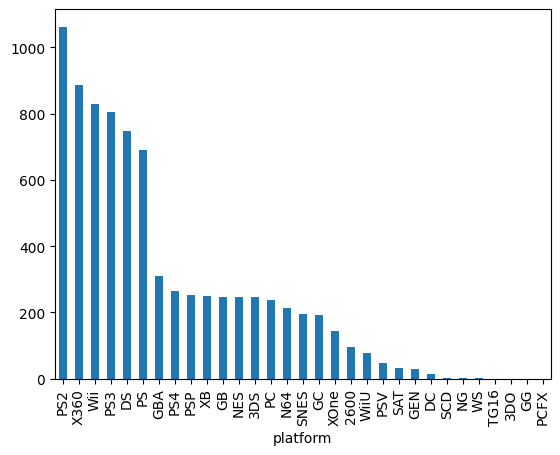

In [27]:
print(games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar'))


In [28]:
top_sales=games_df[games_df['total_sales']>1]
top_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS2     615.98
X360    590.47
Wii     548.48
PS3     484.61
PS      419.95
DS      412.87
GB      230.87
NES     229.75
PS4     196.96
3DS     160.91
GBA     153.71
SNES    140.19
PC      139.86
N64     139.30
XOne    100.69
GC       91.05
XB       87.50
PSP      73.16
2600     50.93
WiiU     45.04
GEN      28.20
DC        8.55
PSV       5.32
SAT       4.10
SCD       1.45
Name: total_sales, dtype: float64

Text(0, 0.5, 'Total Venta Acum')

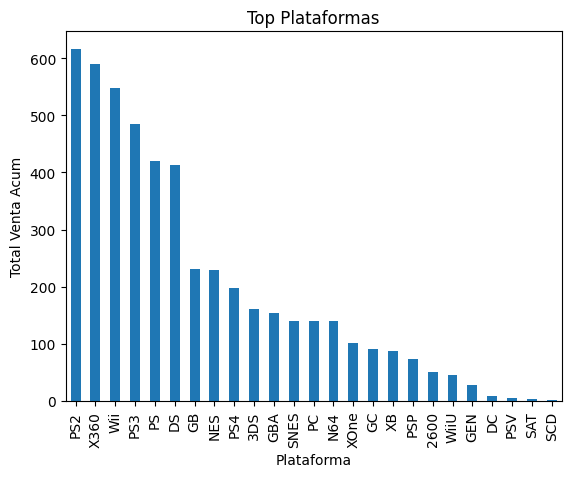

In [29]:
top_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Top Plataformas")
plt.xlabel("Plataforma")
plt.ylabel("Total Venta Acum")

year_of_release  platform
1994             PS            1.18
1995             PS           15.24
1996             PS           53.13
1997             PS           86.86
1998             PS          108.88
1999             PS           85.48
2000             PS           48.81
                 PS2          14.18
2001             PS           13.99
                 PS2         112.07
2002             PS            3.86
                 PS2         120.31
2003             PS            1.16
                 PS2          97.63
2004             DS           11.50
                 PS2         117.99
2005             DS          100.04
                 PS2          80.41
                 X360          3.02
2006             DS           81.38
                 PS2          45.35
                 PS3          11.56
                 Wii         115.15
                 X360         28.41
2007             DS           73.50
                 PS2          11.16
                 PS3          36.31
  

Text(0, 0.5, 'Venta')

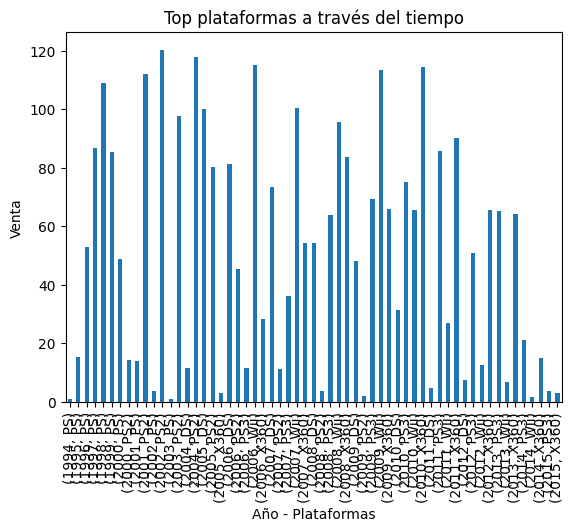

In [30]:
#Evaluando comportamiento por años:
top_platforms = ['PS2','X360','Wii','PS3','PS','DS']
top_platform_df = top_sales[top_sales['platform'].isin(top_platforms) & (top_sales['year_of_release']>0)]
print(top_platform_df.groupby(['year_of_release','platform'])['total_sales'].sum())

top_platform_df.groupby(['year_of_release','platform'])['total_sales'].sum().plot(kind='bar')
plt.title("Top plataformas a través del tiempo")
plt.xlabel("Año - Plataformas")
plt.ylabel("Venta")


AxesSubplot(0.125,0.11;0.775x0.77)


Text(0.5, 0, 'Año')

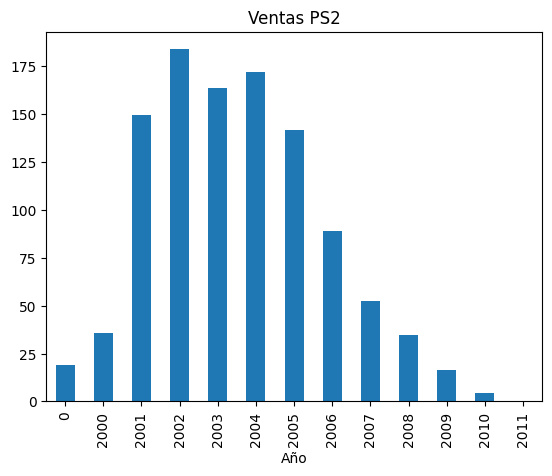

In [31]:
#Revisando el caso de PS2:
PS2_sales = games_df[games_df['platform']=='PS2']
print(PS2_sales.groupby('year_of_release')['total_sales'].sum().plot(kind='bar'))
plt.title("Ventas PS2")
plt.xlabel("Año")


#### Nota 8 
De acuerdo con lo abservado hasta el momento, seis plataformas dominan el volumen acumulado de ventas. 
Las antiguas plataformas (hasta antes de los años 2000) duraban aprox. 10 años entre su aparición y desaparición. 
Después del 2000 ese periodo se redujo a 5 años, siendo una excepción el caso de PS2, que fue lanzada a inicios de los 2000 y duró 10 años.

year_of_release  platform
2006             DS           81.38
                 PS2          45.35
                 PS3          11.56
                 Wii         115.15
                 X360         28.41
2007             DS           73.50
                 PS2          11.16
                 PS3          36.31
                 Wii         100.61
                 X360         54.19
2008             DS           54.42
                 PS2           3.77
                 PS3          63.74
                 Wii          95.54
                 X360         83.71
2009             DS           48.10
                 PS2           1.94
                 PS3          69.39
                 Wii         113.62
                 X360         66.11
2010             DS           31.47
                 PS3          75.20
                 Wii          65.54
                 X360        114.59
2011             DS            4.81
                 PS3          85.89
                 Wii          26.89
  

Text(0, 0.5, 'Ventas')

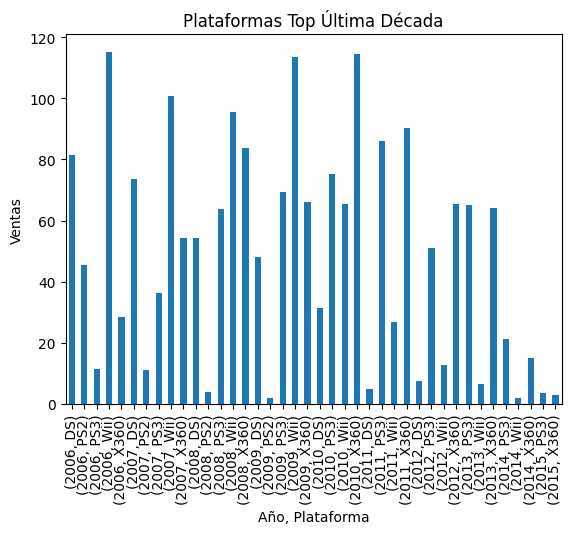

In [32]:
filtered_year = top_platform_df[top_platform_df['year_of_release']>2005]
print(filtered_year.groupby(['year_of_release','platform'])['total_sales'].sum())
print(filtered_year.groupby(['year_of_release','platform'])['total_sales'].sum().plot(kind='bar'))
plt.title("Plataformas Top Última Década")
plt.xlabel("Año, Plataforma")
plt.ylabel("Ventas")

#### Nota 9
En el gráfico previo puede apreciarse el comportamiento de ventas para plataformas líderes durante la última década. Sobresalen los casos de DS y Wii como plataformas que tuvieron auge en 2005 y 2006, para luego caer en 2007, para el caso de Wii, recuperarse en 2008 y 2009 pero luego desaparecer del top; mientras tanto, DS vuelve a reaparecer en 2010 muy por debajo del nivel de 2006 y luego desaparece del top. 
Por otro lado, plataformas como X360 se mantiene estable desde su aparición en 2009, con ligeros crecimientos. 3DS, PS3 y PS4 parecen tener un comportamiento similar a X360.
De acuerdo con lo anterior, las plataformas potencialmente rentables podrían ser PS4, X360 y 3DS teniendo alta relevancia el año de lanzamiento (lo que indicaría vida potencial) además de su comportamiento en ventas.

#### 4.3 Comportamiento de ventas respecto a cada juego y plataforma

count    668.000000
mean       2.949895
std        4.350739
min        1.010000
25%        1.290000
50%        1.795000
75%        2.920000
max       74.090000
Name: total_sales, dtype: float64


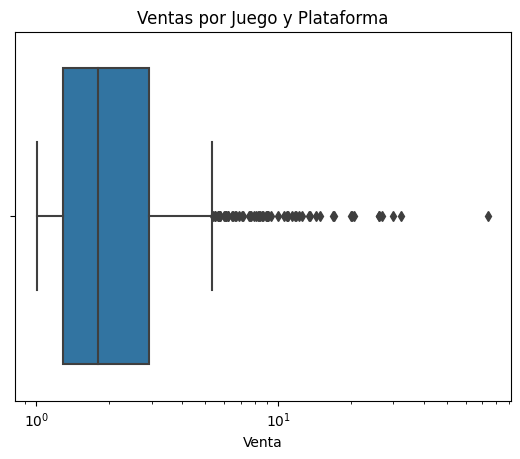

In [37]:
#Regresando a Dataframe original para agruparlo por plataforma:
games_platform = filtered_year.groupby(['name','platform'])['total_sales'].sum()
sns.boxplot(games_platform)
plt.title("Ventas por Juego y Plataforma")
plt.xlabel("Venta")
###
plt.xscale('log') # <- nuevo parametro agregado
###
print(games_platform.describe())





#### Nota 10
De acuerdo con este diagrama de caja para las ventas totales de todos las plataformas, la media se ve claramente afectada por los valores atípicos, quedando por encima de la mediana. La desviación estándar en un valor incluso mayor al propio valor de la media indica lo disperso de los valores como un global. Deberán analizarse por segmentos más específicos.


#### 4.4 Influencia de las reseñas de críticos y usuarios

Text(0, 0.5, 'Venta Total')

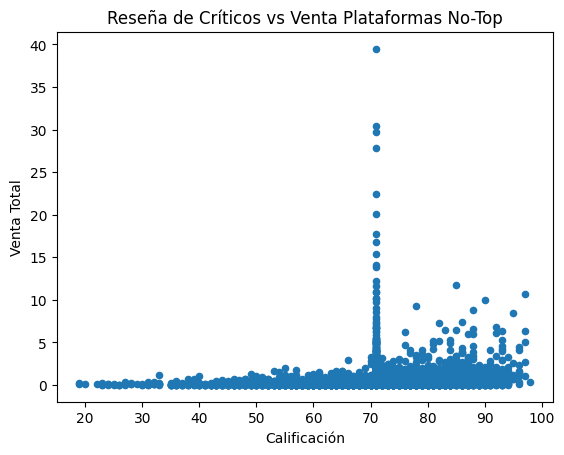

In [38]:
#Relacionando las reseñas de los críticos con las ventas para todas las plataformas excepto las top:
games_df[~games_df['platform'].isin(top_platforms)].plot(kind='scatter',x='critic_score',y='total_sales')
plt.title("Reseña de Críticos vs Venta Plataformas No-Top")
plt.xlabel("Calificación")
plt.ylabel("Venta Total")

Text(0, 0.5, 'Venta Total')

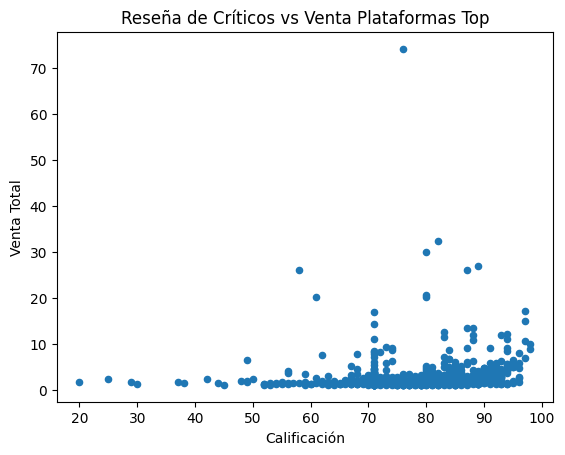

In [39]:
#Relacionando reseñas de críticos con ventas de plataformas Top:
filtered_year.plot(kind='scatter',x='critic_score',y='total_sales')
plt.title("Reseña de Críticos vs Venta Plataformas Top")
plt.xlabel("Calificación")
plt.ylabel("Venta Total")

Text(0, 0.5, 'Venta Total')

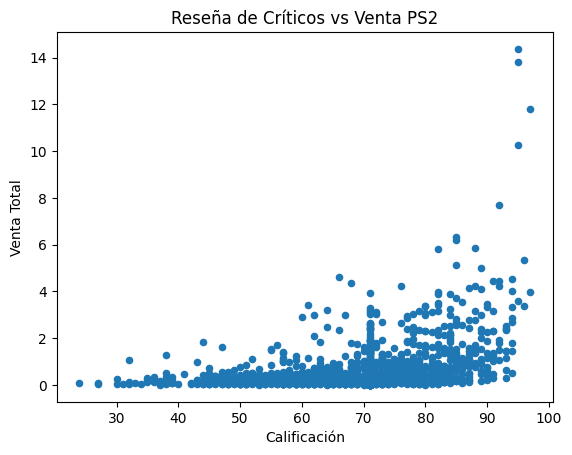

In [40]:
#Relacionando reseñas de críticos con ventas de plataforma PS2:
PS2_sales.plot(kind='scatter',x='critic_score',y='total_sales')
plt.title("Reseña de Críticos vs Venta PS2")
plt.xlabel("Calificación")
plt.ylabel("Venta Total")

Text(0, 0.5, 'Venta Total')

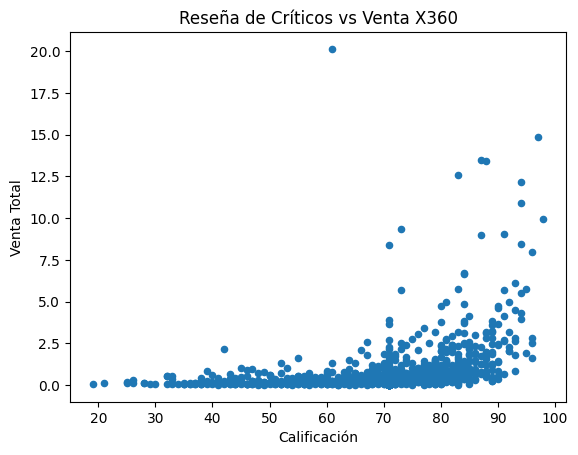

In [41]:
#Relacionando reseñas de críticos con ventas de plataforma X360:
X360_sales = games_df[games_df['platform']=='X360']
X360_sales.plot(kind='scatter',x='critic_score',y='total_sales')
plt.title("Reseña de Críticos vs Venta X360")
plt.xlabel("Calificación")
plt.ylabel("Venta Total")


Text(0, 0.5, 'Venta Total')

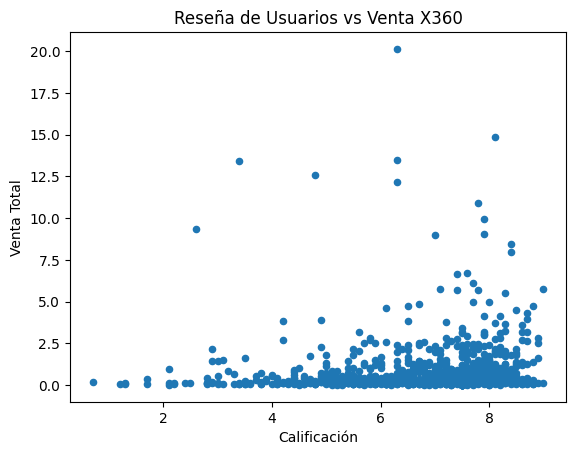

In [42]:
#Relacionando reseñas de usuarios con ventas de plataforma X360:
X360_sales.plot(kind='scatter',x='user_score',y='total_sales')
plt.title("Reseña de Usuarios vs Venta X360")
plt.xlabel("Calificación")
plt.ylabel("Venta Total")

Text(0, 0.5, 'Venta')

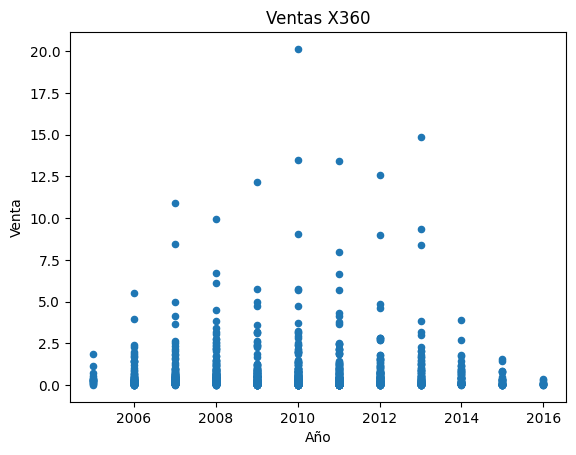

In [43]:
#Dando contexto al nivel de venta de X360:
X360_filter_year = X360_sales[X360_sales['year_of_release']>0]
X360_filter_year.plot(kind='scatter',x='year_of_release',y='total_sales')
plt.title("Ventas X360")
plt.xlabel("Año")
plt.ylabel("Venta")

In [44]:
#Calculo de corvarianza entre reseña de críticos y venta para X360:
x = X360_filter_year['critic_score']
y = X360_filter_year['total_sales']
cov_matrix = np.cov(x,y)

#extracción de valor covarianza:
print("covarianza: ", cov_matrix[0][1])
print("Matriz de correlación: ",X360_filter_year.corr())

covarianza:  6.906355961260505
Matriz de correlación:                   year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.014709  0.044633 -0.126640    -0.004677   
na_sales               -0.014709  1.000000  0.854828  0.486123     0.964488   
eu_sales                0.044633  0.854828  1.000000  0.461634     0.947864   
jp_sales               -0.126640  0.486123  0.461634  1.000000     0.501547   
other_sales            -0.004677  0.964488  0.947864  0.501547     1.000000   
critic_score            0.021915  0.346310  0.348332  0.260232     0.367398   
user_score             -0.218344  0.087192  0.085761  0.163309     0.099648   
total_sales             0.001976  0.985515  0.930125  0.506685     0.990890   

                 critic_score  user_score  total_sales  
year_of_release      0.021915   -0.218344     0.001976  
na_sales             0.346310    0.087192     0.985515  
eu_sales             0.348332    0.085761     0.930125  
jp_sa

#### Nota 11
En todos los casos donde se comparan gráficamente las reseñas tanto de críticos como de usuarios se alcanza a notar una correlación positiva, lo cual se comprueba al calcular la covarianza entre reseña de críticos y ventas totales para la plataforma X360, obteniendo un valor mayor a 0, indicando una correlación positiva, lo cual se confirma también al calcular la correlación en matriz de correlación, indicando una correlación positiva débil.

#### 4.5 Comparativo ventas por juego para diferentes plataformas 

name                                          platform
Wii Sports                                    Wii         74.09
Mario Kart Wii                                Wii         32.23
Wii Sports Resort                             Wii         29.82
New Super Mario Bros.                         DS          26.92
New Super Mario Bros. Wii                     Wii         26.08
Wii Play                                      Wii         26.07
Nintendogs                                    DS          21.93
Mario Kart DS                                 DS          21.31
Wii Fit                                       Wii         20.55
Kinect Adventures!                            X360        20.13
Wii Fit Plus                                  Wii         20.03
Brain Age: Train Your Brain in Minutes a Day  DS          18.10
Grand Theft Auto V                            PS3         17.09
Pokemon Diamond/Pokemon Pearl                 DS          16.88
Grand Theft Auto V                            X36

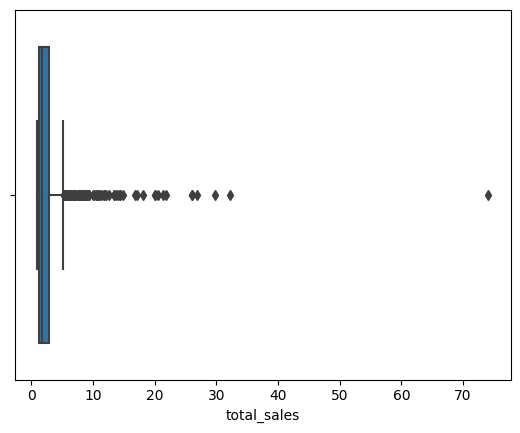

In [45]:
print(top_platform_df.groupby(['name','platform'])['total_sales'].sum().sort_values(ascending=False).head(40))
sns.boxplot(top_platform_df.groupby(['name','platform'])['total_sales'].sum())
print(top_platform_df.groupby(['name','platform'])['total_sales'].sum().describe())

In [46]:
#Identificando y contando juegos que están en más de una plataforma:
game_count = top_platform_df['name'].value_counts()
#creando máscara booleana:
game_dup = game_count[game_count>1].index
#filtrando dataframe de plataformas top con máscara booleana:
game_multiplat = top_platform_df[top_platform_df['name'].isin(game_dup)]
#descripción estadística:
print(game_multiplat.groupby(['name','platform'])['total_sales'].sum().describe())
print(game_multiplat.groupby(['name','platform'])['total_sales'].sum().head(20))


count    346.000000
mean       2.711792
std        2.353829
min        1.010000
25%        1.370000
50%        1.910000
75%        3.050000
max       17.090000
Name: total_sales, dtype: float64
name                             platform
Army of Two                      PS3         1.02
                                 X360        1.48
Assassin's Creed                 PS3         4.00
                                 X360        4.99
Assassin's Creed II              PS3         4.68
                                 X360        4.74
Assassin's Creed III             PS3         5.32
                                 X360        4.85
Assassin's Creed IV: Black Flag  PS3         3.14
                                 X360        3.02
Assassin's Creed: Brotherhood    PS3         2.53
                                 X360        3.26
Assassin's Creed: Revelations    PS3         3.52
                                 X360        3.76
Batman: Arkham Asylum            PS3         3.62
              

Text(0.5, 0, 'Venta')

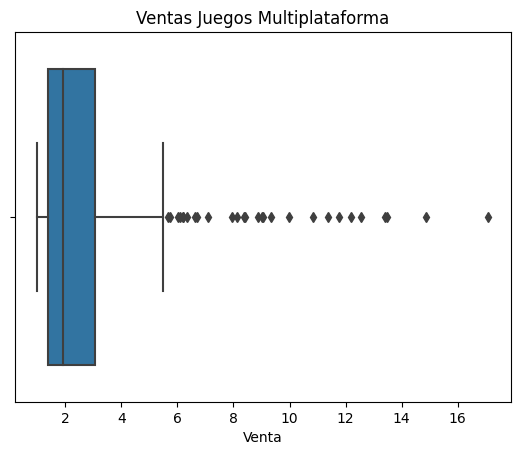

In [47]:
sns.boxplot(game_multiplat.groupby(['name','platform'])['total_sales'].sum())
plt.title("Ventas Juegos Multiplataforma")
plt.xlabel("Venta")

#### Nota 12
De acuerdo con esta última comparativa, las ventas totales para juegos que están en más de una plataforma son similares para el mismo juego entre plataformas. 

#### 4.6 Comportamiento ventas por género

In [48]:
#Análisis de distribución de venta por género de juegos:
print(games_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False))

genre
Action          1559.57
Sports          1196.76
Shooter          948.34
Role-Playing     874.93
Platform         776.68
Misc             728.12
Racing           652.57
Fighting         411.17
Simulation       359.24
Puzzle           230.19
Adventure        221.10
Strategy         163.38
unknown            2.34
Name: total_sales, dtype: float64


#### Nota 13
De acuerdo con este filtro, los géneros más rentables son "Action" y "Sports", seguidos por "Shooter", "Role-Playing" y "Platform".
Definitivamente el género menos rentable es "Strategy".
Seguramente, los géneros con ventas altas estarán presentes en las plataformas con mayores ventas analizadas previamente. 

#### 4.7 Perfiles por región

In [49]:
#Top plataformas por cada región:
#Top global:
print("Top plataformas global:")
print()
print(games_df.groupby(['platform'])['na_sales','eu_sales','jp_sales','total_sales'].sum().sort_values(by='total_sales',ascending=False).head(10))

#Creando columna para proporción de na_sales:
games_df['na_sales_prop'] = games_df['na_sales']/games_df['na_sales'].sum()

#Creando columna para proporción de eu_sales:
games_df['eu_sales_prop'] = games_df['eu_sales']/games_df['eu_sales'].sum()

#Creando columna para proporción de jp_sales:
games_df['jp_sales_prop'] = games_df['jp_sales']/games_df['jp_sales'].sum()
print()
#Plataformas top y su cuota de mercado:
print("Top plataformas global con cuota de mercado por región:")
print()
print(games_df.groupby(['platform'])['na_sales','na_sales_prop','eu_sales','eu_sales_prop','jp_sales','jp_sales_prop','total_sales'].sum().sort_values(by='total_sales',ascending=False).head(5))
print()
print("Top plataformas nacional:")
print(games_df.groupby('platform')['na_sales_prop','na_sales'].sum().sort_values(by='na_sales',ascending=False).head(5))
print()
print("Top plataformas Europa:")
print(games_df.groupby('platform')['eu_sales_prop','eu_sales'].sum().sort_values(by='eu_sales',ascending=False).head(5))
print()
print("Top plataformas Japón:")
print(games_df.groupby('platform')['jp_sales_prop','jp_sales'].sum().sort_values(by='jp_sales',ascending=False).head(5))

Top plataformas global:

          na_sales  eu_sales  jp_sales  total_sales
platform                                           
PS2         583.84    339.29    139.20      1062.33
X360        602.47    270.76     12.43       885.66
Wii         496.90    262.21     69.33       828.44
PS3         393.49    330.29     80.19       803.97
DS          382.40    188.89    175.57       746.86
PS          336.52    213.61    139.82       689.95
GBA         187.54     75.25     47.33       310.12
PS4         108.74    141.09     15.96       265.79
PSP         109.17     66.68     76.78       252.63
XB          186.69     60.95      1.38       249.02

Top plataformas global con cuota de mercado por región:

          na_sales  na_sales_prop  eu_sales  eu_sales_prop  jp_sales  \
platform                                                               
PS2         583.84       0.132620    339.29       0.139932    139.20   
X360        602.47       0.136852    270.76       0.111669     12.43   
Wii  

#### Nota 14
A nivel global las top 5 plataformas son las mismas que se mantienen el el top 5 nacional, muy similar a Europa, salvo el 5to lugar, pero en Japón es muy diferente el top 5, teniendo dentro de este top5 plataformas que no aparecen en el top 5 global.

In [50]:
#Revisando los principales géneros:
#Plataformas top y su cuota de mercado:
print("Top géneros global con cuota de mercado por región:")
print()
print(games_df.groupby(['genre'])['na_sales','na_sales_prop','eu_sales','eu_sales_prop','jp_sales','jp_sales_prop','total_sales'].sum().sort_values(by='total_sales',ascending=False).head(5))
print()
print("Top géneros Nacional:")
print(games_df.groupby('genre')['na_sales_prop','na_sales'].sum().sort_values(by='na_sales',ascending=False).head(5))
print()
print("Top plataformas Europa:")
print(games_df.groupby('genre')['eu_sales_prop','eu_sales'].sum().sort_values(by='eu_sales',ascending=False).head(5))
print()
print("Top plataformas Japón:")
print(games_df.groupby('genre')['jp_sales_prop','jp_sales'].sum().sort_values(by='jp_sales',ascending=False).head(5))

Top géneros global con cuota de mercado por región:

              na_sales  na_sales_prop  eu_sales  eu_sales_prop  jp_sales  \
genre                                                                      
Action          879.01       0.199668    519.13       0.214103    161.43   
Sports          684.43       0.155469    376.79       0.155398    135.54   
Shooter         592.24       0.134528    317.34       0.130880     38.76   
Role-Playing    330.81       0.075144    188.71       0.077829    355.41   
Platform        445.50       0.101196    200.35       0.082630    130.83   

              jp_sales_prop  total_sales  
genre                                     
Action             0.124429      1559.57  
Sports             0.104473      1196.76  
Shooter            0.029876       948.34  
Role-Playing       0.273947       874.93  
Platform           0.100842       776.68  

Top géneros Nacional:
          na_sales_prop  na_sales
genre                            
Action         0.19966

#### Nota 15
Los 5 géneros principales tanto en global como en nacional y Europa son muy similares, con los 3 primeros en el mismo orden de preferencia: Action, Sports, Shooter. El caso de Japón nuevamente es diferente, al tener en primer lugar Role-Playing, seguido de Action y Sports.
Seguramente las principales diferencias en esta preferencia tengan que ver con diferencias culturales y sociales. Interesante la coincidencia en 4to lugar tanto en Japón como en Nacional para el género Platform.

In [51]:
#Revisando efecto de calificaciones ESRB:
print(games_df.groupby(['rating'])['na_sales','eu_sales','jp_sales','total_sales'].sum().sort_values(by='total_sales',ascending=False).head(5))
print()



        na_sales  eu_sales  jp_sales  total_sales
rating                                           
E        1292.99    710.25    198.11      2201.35
T         759.75    427.03    151.40      1338.18
M         748.48    483.97     64.24      1296.69
E10+      353.32    188.52     40.20       582.04
K-A         2.56      0.27      1.46         4.29



#### Nota 16
Al parecer hay una influencia del rating E (everyone) seguido de T (Teenage). Estos dos ratings registran el mayor volumen de ventas tanto a nivel global como por regiones.

#### 5.0 Pruebs de hipótesis
#### Hipótesis 1:
Hipótesis a probar: "Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas".

Hipótesis nula : las calificaciones promedio de los usuarios para Xbox One y PC son las mismas.

Hipótesis alternativa: las calificaciones promedio de los usuarios par Xbox y PC son diferentes.


In [52]:
#Aplicando prueba de hipótesis:
#Filtrando DFs: 
xone_sample = games_df[games_df['platform']=='XOne']
pc_sample = games_df[games_df['platform']=='PC']

#Sustituyendo valores vacíos por 0 en user_score para ambos DF nuevos:
xone_sample['user_score'].fillna(0,inplace=True)
pc_sample['user_score'].fillna(0,inplace=True)

#Definiendo valor alpha:
alpha = 0.05

#Aplicando prueba t:
results = st.ttest_ind(xone_sample['user_score'],pc_sample['user_score'])

#Obteniendo valor p:
print('valor p: ',results.pvalue)

if results.pvalue<alpha:
    print("rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")



valor p:  9.312425122631339e-05
rechazamos la hipótesis nula


/.venv/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


#### Hipótesis 2
Hipótesis a probar: "Las calificaciones promedio de los usarios para los géneros de Acción y Deportes son diferentes".

Hipótesis nula: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.

Hipótesis alternativa: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [53]:
#Filtrando DF original para obtener muestras:
action_df = games_df[games_df['genre']=='Action']
sports_df = games_df[games_df['genre']=='Sports']

#sustituyendo valores vacíos para user_score en ambos DF nuevos:
action_df['user_score'].fillna(0,inplace=True)
sports_df['user_score'].fillna(0,inplace=True)

#Estableciendo valor de alpha:
alpha = 0.05

#Aplicando prueba estadística:
results = st.ttest_ind(action_df['user_score'],sports_df['user_score'])

#Obteniendo valor p:
print('valor p: ',results.pvalue)

if results.pvalue<alpha:
    print("rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.4072439259713323
No podemos rechazar la hipótesis nula


#### Nota 17 
Se ha decidido utilizar prueba t para ambas hipótesis dado que se trataban dos poblaciones a comparar.

Se decidió utilizar un valor alpha en 5% como primer aproximación, resultando adecuado para ambos casos.

En ambas pruebas se ha definido la hipótesis nula como aquella que representa la igualdad.

De las pruebas aplicadas, se concluye como rechazada la Hipótesis 1 (también definida como hipótesis nula), referida a la igualdad entre los valores promedio para las calificaciones de usuarios hacia Xbox One y PC; mientras tanto, para el caso de la Hipótesis 2, la cual es congruente con la hipótesis alternativa, se ha establecido como más probable la hipótesis nula (al menos un 40.7%), con lo cual se puede decir que los promedios de calificaciones de usuarios para los géneros de Acción y Deportes son al menos un 40.7% probables de ser iguales.

### 6.0 Conclusión General
Las ventas de videojuegos a lo largo de los años desde su aparición masiva en la década de los 80s hasta hoy en día, muestran cambios que van asociados tanto a la evolución tecnológica como a posibles cambios culturales y de preferencias, tanto a nivel global como por regiones. 

Así pues, se hace notorio que a pesar de estos cambios, a lo largo de la historia, los volumenes de venta globales son lideeados por 6 plataformas, algunas de las cuales tuvieron periodos de auge y luego han desaparecido o evolucionado, mientras otras se mantienen más o menos estables por periodos más largos. Sobresale también el comportamiento en el lanzamiento de juegos por plataforma a lo largo de los años, con un desarrollo lineal por debajo de los 100 por año entre los80s y mediados de los 90s, luego una aceleración casi exponencial hasta 2005, luego una estabilización alta en 2005-2011 para luego tener una decaída y estabilización en niveles alrededor de 500 anuales, lo cual indica que ya es una industria madura. 

Al hacer un a revisión más específica por regiones, se hacen patentes las diferencias y coincidencias culturales, marcando géneros e incluso plataformas que son exitosos en una región particular pero no en el resto de regiones, así como otras plataformas y géneros que son exitosos tanto a nivel global como en el resto de regiones. Con esto como contexto se podría decir que para establecer un modelo adecuado para estimar comportamientos futuros, deben considerarse al menos dos tipos de perfil, uno para la región Japón (dirigido por ejemplo a plataformas como DS y en géneros como Role-Playing) y otro para el resto del mundo dirigido a plataformas como PS4, X360 y 3DS en géneros de Acción y Deportes. 

Por otro lado, las pruebas de correlación para plataformas seleccionadas dentro de las top,mostraron correlación positiva entre las calificaciones de criticos y niveles de venta, algo a tener en cuenta a la hora de testear. 